# pip and import

In [1]:
!pip install datasets
!pip install conllu

import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset

!pip install transformers
!pip install evaluate

from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt
from numpy import number
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

# Dataset

The following functions are borrowed from the second laboratory of the course.

In [2]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [3]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


## Dataset analysis
UD English_LinES is a subset of the LinES Parallel Treebank, focusing on the English language. It contains literature, online manual, and Europarl data.

The original dependency annotations were automatically converted to Universal Dependencies and partially reviewed. Each segment in the dataset has a corresponding translation in the UD Swedish_LinES treebank but we focused on the english part.

Ongoing development efforts are being made to improve the treebank.

In [4]:
# build a dictionary counting the number of occurrences of each type of the dataset
# and a list containing the number of word for each phrase
types = {}
phrase_lengths = []
for dataset in train_dataset, dev_dataset, test_dataset:
  for s in dataset:
    phrase_lengths.append(len(s['tokens']))
    for t in s['tokens']:
      types[t] = types.get(t, 0) + 1

Number of phrases:  5243
Numbert of types:  11096
Numbert of tokens:  94217
Average phrase length:  17.97
Top 10 most frequent types in the dataset:
-  ,     4970 occurrences
-  the   4780 occurrences
-  .     4709 occurrences
-  of    2228 occurrences
-  to    2191 occurrences
-  and   2181 occurrences
-  a     2153 occurrences
-  in    1338 occurrences
-  was   1117 occurrences
-  I      981 occurrences


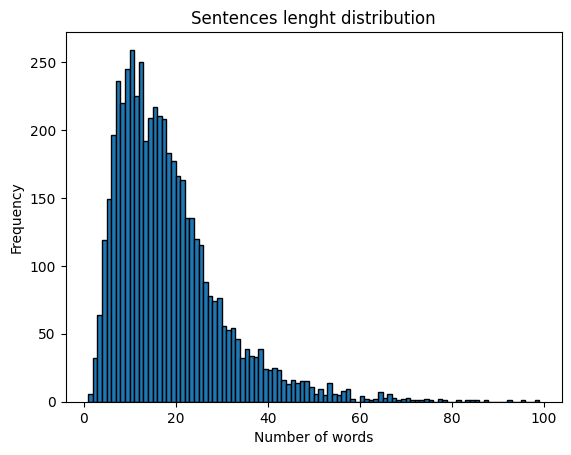

In [5]:
print('Number of phrases: ',len(train_dataset) + len(dev_dataset) + len(test_dataset))
print('Numbert of types: ', len(types))
print('Numbert of tokens: ', sum(phrase_lengths))
print(f'Average phrase length:  {sum(phrase_lengths)/len(phrase_lengths):.2f}')

most_frequent_types = sorted(types.items(), key=lambda x: x[1], reverse=True)[:10]

print('Top 10 most frequent types in the dataset:')
for key, value in most_frequent_types:
    print(f'-  {key:5}{value:5} occurrences')

plt.hist(phrase_lengths, bins=range(min(phrase_lengths), max(phrase_lengths) + 2), edgecolor='black')

plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Sentences lenght distribution')

plt.show()

From the histogram above we can easily see that the dataset consists mainly of medium-length sentences (almost 18 words per sentence)

# Parsing

## ArcEager Parser
This parser takes into account configurations composed by the top-stack element *s* and the first buffer item *b*. The four performable moves are:
- **shift**: pushes *b* to the stack
- **left_arc**: creates an arc *b* -> *s* and pops s from the stack
- **right_arc**: creates an arc *s* -> *b* and pushes b to the stack
- **reduce**: pops the stack

In [6]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    self.shift()

  def shift(self):
    b = self.buffer.pop(0)
    self.stack.append(b)

  def reduce(self):
    self.stack.pop()

  def left_arc(self):
    s = self.stack.pop()
    b = self.buffer[0]
    self.arcs[s] = b

  def right_arc(self):
    s = self.stack[-1]
    b = self.buffer.pop(0)
    self.arcs[b] = s
    self.stack.append(b)

  def is_tree_final(self):
    return (not self.buffer)

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

## Oracle
The oracle determines the next move given the parser current configuration and the gold tree, verifying that there are conditions to execute the move.

Moreover, it sets precedences among the four aformentioned moves in order to avoid spurious ambiguity (shift has precedence over reduce).

In [7]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if s != 0 and self.parser.arcs[s] == -1 and self.gold[s] == b:
      return True

    return False

  def is_right_arc_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if self.gold[b] == s:
      return True

    return False

  def is_reduce_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if (self.is_left_arc_gold() or self.is_right_arc_gold()):
      return False

    for k in self.parser.stack:
      if (k < s and (self.gold[k] == b or self.gold[b] == k)):
        return True

    return False

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

## Parser test

This test proves the correctness of our parser.

In [8]:
def parse_dataset(dataset):
  for sample in dataset:
    sentence = ['<ROOT>'] + sample['tokens']
    gold_tree = sample['head']
    gold_tree = [-1] + [int(key) for key in gold_tree]

    if not is_projective(gold_tree): # the parser does not work with non-projective tree
      continue
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold_tree)
    while not parser.is_tree_final():
      if oracle.is_left_arc_gold():
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
      elif oracle.is_reduce_gold():
        parser.reduce()
      else:
        parser.shift()
    parse_tree = parser.arcs
    if parse_tree != gold_tree:
      return False
  return True

print(parse_dataset(train_dataset))

True


# Models

##BiLSTM model

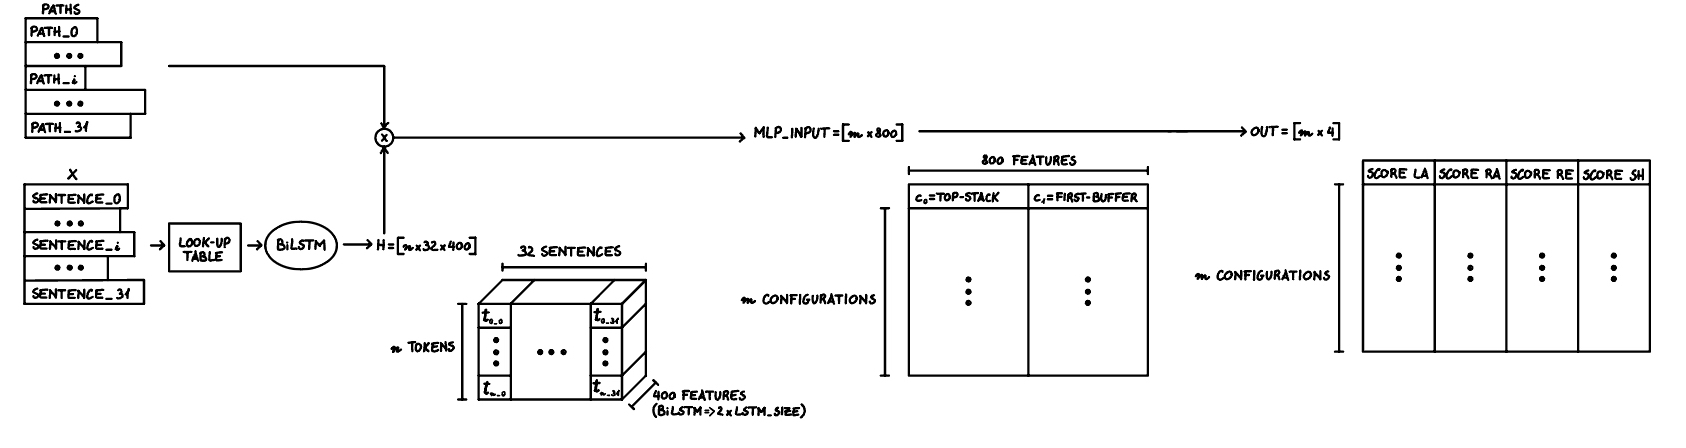

The model is composed by a BiLSTM topped by a multi-layer perceptron (MLP).

##Training
The model receives in input **sentences** and **paths** of a batch.

Exploiting *nn.Embedding* we build a look-up table to retrieve word embeddings only using integer indexes.

The *lstm_pass* produces a tensor **h** containing the embeddings of the tokens in the sentences received in input and padding the batch **x** to even out the number of tokens per sentence. This tensor has shape [maximum number of tokens in a sentence of the batch, BATCH_SIZE, 2*LSTM_SIZE], the number of features represented by the third dimension doubles the LSTM_SIZE since we are using a BiLSTM producing an embedding that takes into account both the left and the right context.

Once we have our embeddings tensor **h**, we can compute the **mlp_input** through *get_mlp_input* combining the information in **h** with the one in **paths**.

Let's make an example to understand what's happening: in the image below we compute the path obtained from the dependency parsing of the sentence "I like pizza.". A path is the list of configurations, couples [index of the word in the top-stack position, index of the word in the first-buffer position], encountered while parsing the sentence. Combining **paths** with **h**, we substitute the indexes of the words with their embeddings.

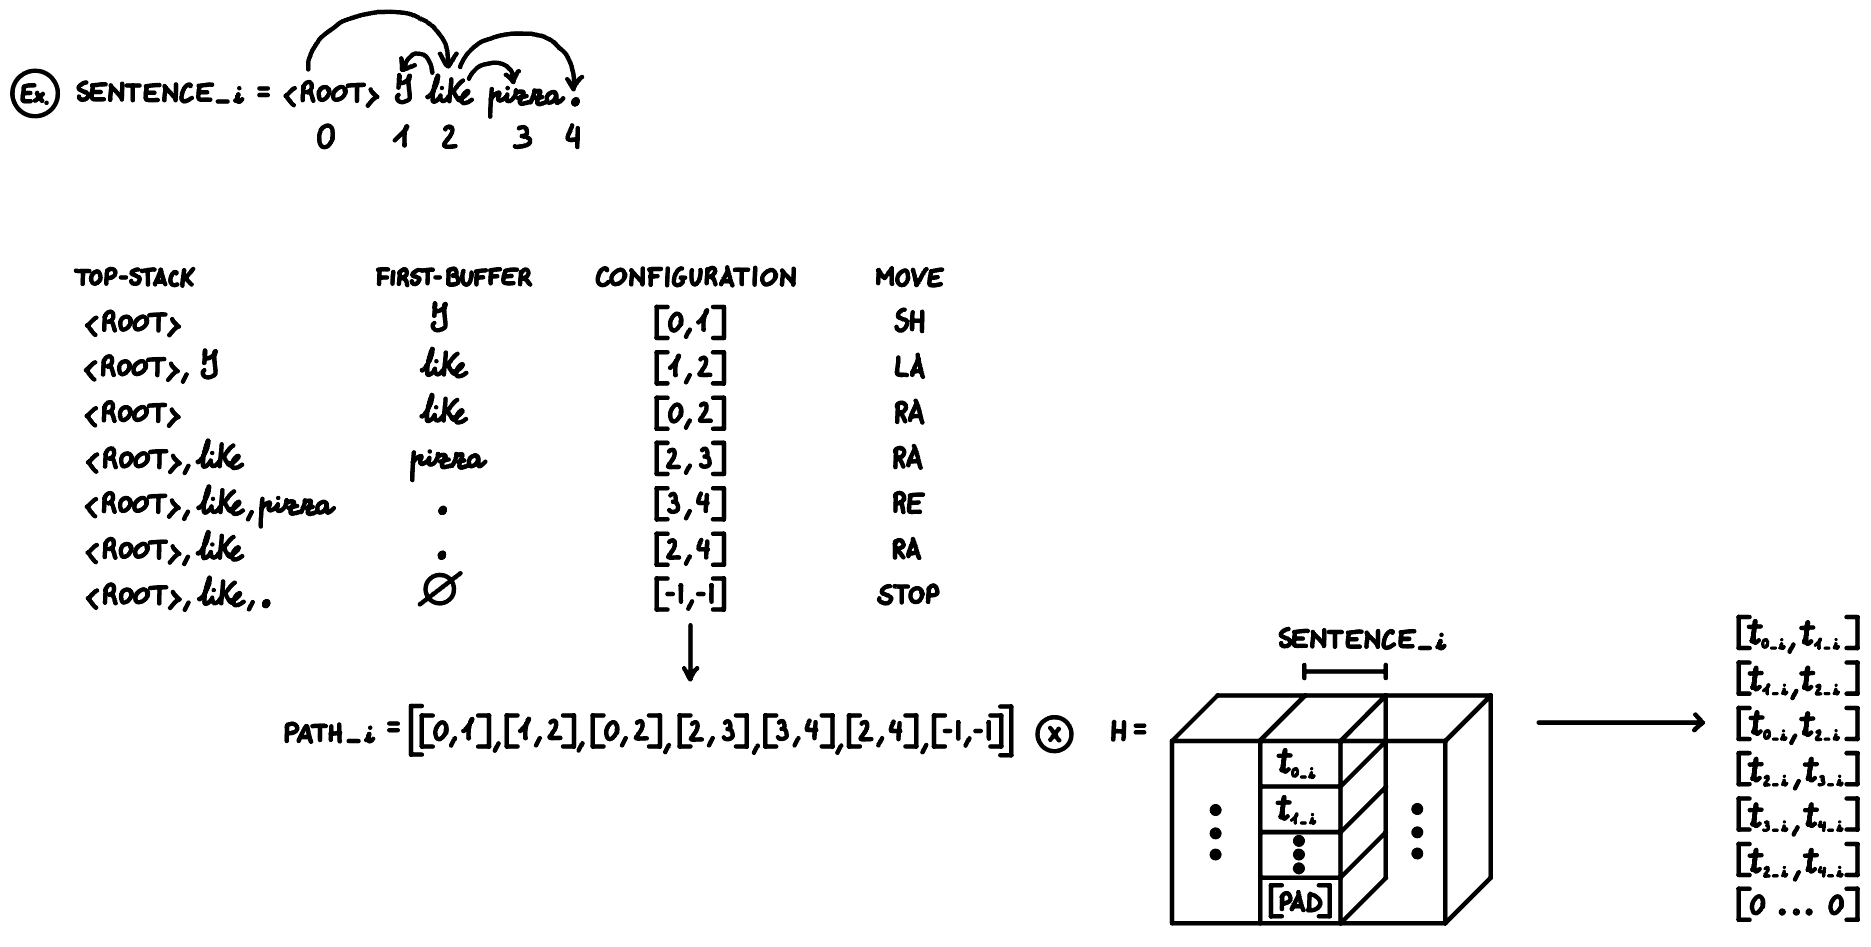

Finally, **mlp_input** is fed to the MLP and the model returns a 2-dimensional tesor of scores. We compute scores for all four moves for each configuration from the concatenation of all configurations of every sentence in the batch.

The cross-entropy loss compares **out** with **moves**, checking whether the highest score is correctly assigned to the gold move.

##Inference
The model receives in input **sentences**.

The main difference w.r.t. training is that we have to compute also the paths (i.e. the configurations for each sentence in **sentences**). In order to do so, we initialize a list **parsers** of **BATCH_SIZE** arc-eager parsers, one per sentence. After obtaining the **h** tensor as in the training, we iterate on the sentences until each parser has reached the final configuration (a.k.a. has parsed the sentence). At each iteration, we parallely compute the current configuration for each sentence through *get_configurations* and the next move for each parser through *parse_step*, saving the dependency trees in the **.arcs** field of the parsers.

Finally, we compare the predicted dependency tree with the gold ones.

In [9]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001 # learning rate

In [10]:
class BilstmParser(nn.Module):

  def __init__(self, device):
    super(BilstmParser, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(4*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):

    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x) # size(longest_sentence, batch_size, features)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # in this function we select and perform the next move according to the scores obtained.
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0: # left_arc
          if parsers[i].stack[-1] != 0: # if the top-most element of the stack is not the root we can apply left_arc
            parsers[i].left_arc()
          else:
            if moves[i][2] > moves[i][1]:
              parsers[i].shift()
            else:
              parsers[i].right_arc()
        elif moves_argm[i] == 1: # right_arc
          parsers[i].right_arc() # Arc Eager consider the empty buffer case as final, making useless to check conditions for right_arc
        elif moves_argm[i] == 2: # shift
          parsers[i].shift() # Arc Eager consider the empty buffer case as final, making useless to check conditions for shift
        elif moves_argm[i] == 3: # reduce
          if parsers[i].stack[-1] != 0: # if the top-most element of the stack is not the root we can apply reduce
            parsers[i].reduce()
          else:
            if moves[i][2] > moves[i][1]:
              parsers[i].shift()
            else:
              parsers[i].right_arc()

##BERT model

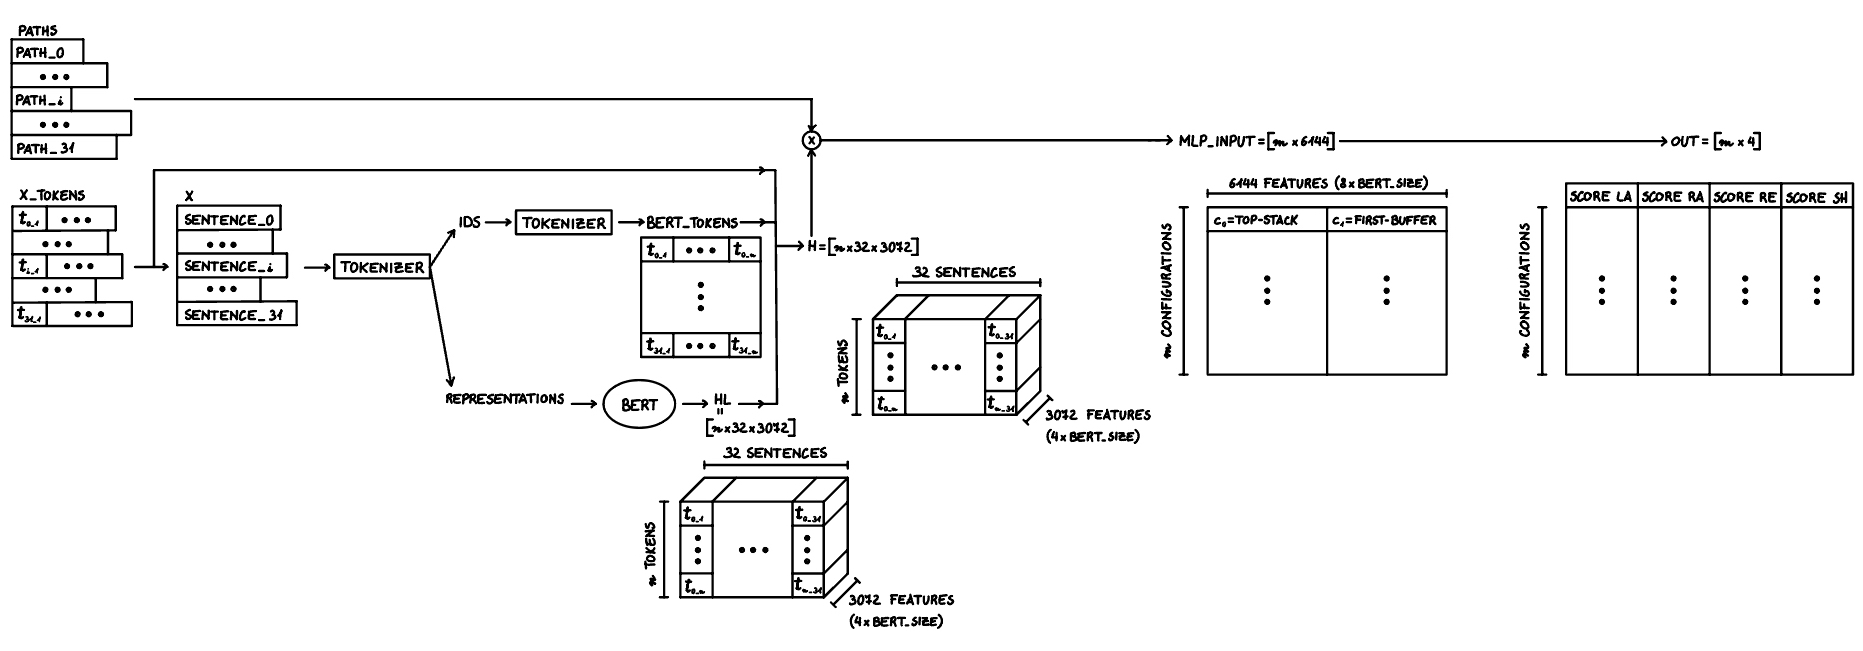

The model consists of the BERT encoder and a multi-layer perceptron (MLP) on top of it.

As long as data is concerned, the main difference is that in BERT we pass tokens as strings of characters to exploit its tokenization. Furthermore, we no longer need a lookup table (*nn.Embedding* class) given that BERT already takes care of it.

##Training
The model receives in input **sentences** and **paths**.

First we "restore" the sentences through the *sentence_join* function, so that BERT can properly exploits the transformers architecture generating contextual embeddings.

Additionally, we save them in the list **x**: this is done to feed BERT with a batch of sentences instead of a sentence at a time, thus reducing the processing time required. When dealing with batches, BERT requires their elements to have the same dimensions: fortunately it is all taken care of by the BERT tokenizer, that, as the name suggest, tokenizes the sentences adding a special token [PAD] to even out the number of tokens per sentence in the batch. It is pivotal to stress that the BERT tokenizer performs a subword tokenization, meaning that, from a single word, one or more subtokens are generated.

Through the *get_bert_layers* function we save into:
- **hl** = the BERT encodings of the tokens generated by the tokenizer concatenating the hidden embeddings of the last four BERT encoder layers;
- **ids** = the input_ids used by BERT to uniquely identify the tokens.

Before combining the encodings with **paths**, we need to average those belonging to words that generated subtokens, so that the indexes in the configurations, indicating the word position in the sentence, can be associated to a "complete" word and not just a fragment of it. Therefore we use the *get_bert_encodings* function, exploiting **ids** to reconstruct BERT tokens comparing them with **x_tokens** (= **sentences** given as input to the model containing the "true tokens").

Once we have our embeddings tensor **h**, we can compute the **mlp_input** through *get_mlp_input* that combines the information in **h** with the one in **paths** (as we did in the previous model). Just to have a clear picture of the process, we want to highlight how the features associated to the [PAD] tokens won't affect the **mlp_input**, since they don't correspond to any configurations, the inner for cycle of *get_mlp_input* stops before inspecting the padded tail of the sentences in **h**.

Finally, **mlp_input** is fed to the MLP and the model returns a 2-dimensional tesor of scores. We compute scores for all four moves for each configuration from the concatenation of all configurations of every sentence in the batch.

The cross-entropy loss compares **out** with **moves**, checking whether the highest score is correctly assigned to the gold move.

##Inference
The model receives in input **sentences**.

The main difference w.r.t. training is that we have to compute also the paths (i.e. the configurations for each sentence in **sentences**). In order to do so, we initialize a list **parsers** of **BATCH_SIZE** arc-eager parsers, one per sentence. After obtaining the **h** tensor as in the training, we iterate on the sentences until each parser has reached the final configuration (a.k.a. has parsed the sentence). At each iteration, we parallely compute the current configuration for each sentence through *get_configurations* and the next move for each parser through *parse_step*, saving the dependency trees in the **.arcs** field of the parsers.

Finally, we compare the predicted dependency tree with the gold ones.

#Choices
Our BERT-based model takes textual tokens as input for each sentence, this is to take full advantage of the sub-tokenization that the model implements.

In the first version of the BERT tokens encodings we simply took the last hidden layer of the model, this way we were getting good but not incredible results.
That being said, we decided to concatenate the last four hidden states in order to have much more information for each tokens, in this way both the loss and the UAS score improved a lot.

As previously explained, BERT performs a sub-tokenization of words. To obtain an encoding for the actual tokens of the sentence, we associated each "true token" encoding with the average of the encodings of all its sub-tokens.
Another option would have been to associate the left-most sub-token encoding, but we would have lost a lot of information.

In [11]:
BERT_SIZE = 768
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
MLP_LR = 0.001
BERT_LR = 0.0001
FT_START = 3

In [12]:
class BertParser(nn.Module):

  def __init__(self, device):
    super(BertParser, self).__init__()
    self.device = device

    # initialize BERT
    self.bert = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # initialize feedforward
    self.w1 = torch.nn.Linear(8*BERT_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x_tokens, paths):

    # rebuild the full sentences from the tokens
    x = []
    for i in x_tokens:
      x.append(self.sentence_join(i))

    # run BERT to get the encodings
    hl, ids = self.get_bert_layers(x)

    # get the actual encodings to get a prediction
    h = self.get_bert_encodings(hl, ids, x_tokens)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  # this function returns the concatenation of the four final BERT hidden layers
  def get_bert_layers(self, x):

    representations = self.tokenizer(x, padding=True, add_special_tokens=False, return_tensors='pt')
    ids = representations["input_ids"].to(self.device)
    representations.to(self.device)
    bert_hidden_layers = self.bert(**representations).hidden_states

    bert_hidden_layers = torch.cat([bert_hidden_layers[-4], bert_hidden_layers[-3], bert_hidden_layers[-2], bert_hidden_layers[-1]], dim=2)

    return bert_hidden_layers, ids

  # this function returns the encoding for each tokens of the phrase
  # for each word it averages over the bert embeddings each of the subtokens computed
  def get_bert_encodings(self, hl, bert_ids, true_tokens):

    encodings = torch.zeros(hl.shape).to(self.device)

    for s in range(len(hl)):
      bert_tokens = self.tokenizer.convert_ids_to_tokens(bert_ids[s])
      i = 0
      j = 0
      while i in range(len(true_tokens[s])):
        temp = ""
        count = 0
        while (len(temp) < len(true_tokens[s][i])):
          if bert_tokens[j][0:2]=="##":
            bert_tokens[j] = bert_tokens[j][2:]
          temp += bert_tokens[j]
          encodings[s][i] += hl[s][j]
          j += 1
          count += 1
        encodings[s][i] = encodings[s][i]/count
        i += 1
    encodings = encodings.permute(1, 0, 2)

    return encodings

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(4*BERT_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)

    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # reconstruct the sentence from its tokens
  def sentence_join(self, tokens):
    sentence = ""
    for token in tokens:
      sentence = sentence + " " + token
    return sentence

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x_tokens):

    parsers = [ArcEager(i) for i in x_tokens]

    x = []
    for i in x_tokens:
      x.append(self.sentence_join(i))

    hl, ids = self.get_bert_layers(x)

    # get the actual encodings to get a prediction
    h = self.get_bert_encodings(hl, ids, x_tokens)


    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)

      mlp_input = self.get_mlp_input(configurations, h)

      mlp_out = self.mlp(mlp_input)

      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # in this function we select and perform the next move according to the scores obtained
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0: # left_arc
          if parsers[i].stack[-1] != 0: # if the top-most element of the stack is not the root we can apply left_arc
            parsers[i].left_arc()
          else:
            if moves[i][2] > moves[i][1]:
              parsers[i].shift()
            else:
              parsers[i].right_arc()
        elif moves_argm[i] == 1: # right_arc
          parsers[i].right_arc() # Arc Eager consider the empty buffer case as final, making useless to check conditions for right_arc
        elif moves_argm[i] == 2: # shift
          parsers[i].shift() # Arc Eager consider the empty buffer case as final, making useless to check conditions for shift
        elif moves_argm[i] == 3: # reduce
          if parsers[i].stack[-1] != 0: # if the top-most element of the stack is not the root we can apply reduce
            parsers[i].reduce()
          else:
            if moves[i][2] > moves[i][1]:
              parsers[i].shift()
            else:
              parsers[i].right_arc()

## Parse step for the ArcEager parser

The *parse_step* function (in both models) selects the next move according to the scores obtained, however we need to make sure that the move is performable.

The only condition we decided to check is for the left-arc and the reduce moves: no word can be the head of the root, so when the in top stack position there is the root the left-arc move is illegal. In the same situation, the reduce move would make no sense: we would end up with an empty stack forcing a shift of the buffer, resulting in an extra operation.

Even if we could have applied more hard coded rules, we decided to stick up with our approach. Allowing the model to make mistakes we belive it better learns how to accomplish its parsing task.

After a quick confrontation with other groups we noticed that our "less constrained" *parse_step* led to better results, this convinced us of pursuing this way.

# Training and Data Preparation

## Data Preparation
For our training we had to extract the non-projective trees from the training set: the implementations of the arc-eager parser and the oracle follow the guidelines of [this paper](https://aclanthology.org/C12-1059.pdf), where it is explicitly said that this kind of trees isn't considered.

In [13]:
# remove the non projective trees in the train dataset
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

We modified the secondo lab's function by adding a flag for the BERT case, returning tokens of characters instead of tokens of integers.
As already explained in the BERT model section, if we want to exploit the sub-tokenization of BERT it makes no sense returning a list of integers.

In [14]:
def process_sample(sample, get_gold_path = False, is_bert=False):
  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift, 3 reduce

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        parser.left_arc()
        gold_moves.append(0)
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)

  # if is_bert == True then return the list of text tokens instead of list of integer tokens
  if is_bert:
    return sentence, gold_path, gold_moves, gold
  else:
    return enc_sentence, gold_path, gold_moves, gold

We exctract from the train/test dataset batches, each composed by:
- **sentences**:
  - BiLSTM model: list of BATCH_SIZE lists, each containing the input ids (integer numbers) of the tokenized words (one word, one token) composing a sentence
  - BERT model: list of BATCH_SIZE lists, each containing the tokenized words (one word, one token) composing a sentence
- **paths**: list of BATCH_SIZE lists, each containing all the configurations obtained while parsing the sentences in the batch
- **moves**: list gold moves to obtain the gold dependency trees
- **trees**: list of gold dependency trees

In [15]:
def prepare_batch(batch_data, get_gold_path=False, is_bert=False):
  data = [process_sample(s, get_gold_path=get_gold_path, is_bert=is_bert) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data] # input_ids
  paths = [s[1] for s in data] # sequence of configurations
  moves = [s[2] for s in data] # sequence of moves
  trees = [s[3] for s in data] # gold_tree
  return sentences, paths, moves, trees

In [16]:
BATCH_SIZE = 32

bilstm_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
bilstm_dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
bilstm_test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

bert_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True, is_bert=True))
bert_dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, is_bert=True))
bert_test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, is_bert=True))

In [17]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

## BiLSTM training

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
BiLSTM_model = BilstmParser(device)
BiLSTM_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(BiLSTM_model.parameters(), lr=LR)

# lists to store losses and scores for later being put into the graphs
bilstm_losses = []
bilstm_scores = []

start = time.time()

for epoch in range(EPOCHS):
  avg_train_loss = train(BiLSTM_model, bilstm_train_dataloader, criterion, optimizer)
  val_uas = test(BiLSTM_model, bilstm_dev_dataloader)

  bilstm_losses.append(avg_train_loss)
  bilstm_scores.append(val_uas)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

end = time.time()

# minutes of training time
bilstm_training_time = (end - start)/60

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 1.080 | dev_uas: 0.596 |
Epoch:   1 | avg_train_loss: 0.951 | dev_uas: 0.652 |
Epoch:   2 | avg_train_loss: 0.919 | dev_uas: 0.679 |
Epoch:   3 | avg_train_loss: 0.899 | dev_uas: 0.693 |
Epoch:   4 | avg_train_loss: 0.883 | dev_uas: 0.699 |
Epoch:   5 | avg_train_loss: 0.872 | dev_uas: 0.710 |
Epoch:   6 | avg_train_loss: 0.863 | dev_uas: 0.713 |
Epoch:   7 | avg_train_loss: 0.855 | dev_uas: 0.716 |
Epoch:   8 | avg_train_loss: 0.848 | dev_uas: 0.714 |
Epoch:   9 | avg_train_loss: 0.842 | dev_uas: 0.718 |
Epoch:  10 | avg_train_loss: 0.837 | dev_uas: 0.720 |
Epoch:  11 | avg_train_loss: 0.834 | dev_uas: 0.720 |
Epoch:  12 | avg_train_loss: 0.828 | dev_uas: 0.728 |
Epoch:  13 | avg_train_loss: 0.825 | dev_uas: 0.730 |
Epoch:  14 | avg_train_loss: 0.820 | dev_uas: 0.732 |


## BERT training



In [19]:
print("Device:", device)
BERT_model = BertParser(device)
BERT_model.to(device)

criterion = nn.CrossEntropyLoss()

# we define two different optimizer to perform fine tuning on bert
# the first trains only the MLP layers (BERT layer learning rate = 0)
# the second trains every layer, with a smaller learning rate for BERT
initial_optimizer = torch.optim.Adam([
    {'params': BERT_model.w1.parameters(), 'lr': MLP_LR}, # lr for w1
    {'params': BERT_model.w2.parameters(), 'lr': MLP_LR} # lr for w2
])
fn_optimizer = torch.optim.Adam([
    {'params': BERT_model.bert.parameters(), 'lr': BERT_LR}, # lr for bert
    {'params': BERT_model.w1.parameters(), 'lr': MLP_LR}, # lr for w1
    {'params': BERT_model.w2.parameters(), 'lr': MLP_LR} # lr for w2
])

# lists to store losses and scores for later being put into the graphs
bert_losses = []
bert_scores = []

start = time.time()

for epoch in range(EPOCHS):
  if epoch < FT_START:
    avg_train_loss = train(BERT_model, bert_train_dataloader, criterion, initial_optimizer)
  else:
    avg_train_loss = train(BERT_model, bert_train_dataloader, criterion, fn_optimizer)
  val_uas = test(BERT_model, bert_dev_dataloader)

  bert_losses.append(avg_train_loss)
  bert_scores.append(val_uas)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch, avg_train_loss, val_uas))

end = time.time()

# minutes of training time
bert_training_time = (end - start)/60

Device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0 | avg_train_loss: 1.000 | dev_uas: 0.721 |
Epoch:   1 | avg_train_loss: 0.911 | dev_uas: 0.755 |
Epoch:   2 | avg_train_loss: 0.896 | dev_uas: 0.765 |
Epoch:   3 | avg_train_loss: 0.853 | dev_uas: 0.868 |
Epoch:   4 | avg_train_loss: 0.809 | dev_uas: 0.883 |
Epoch:   5 | avg_train_loss: 0.792 | dev_uas: 0.892 |
Epoch:   6 | avg_train_loss: 0.784 | dev_uas: 0.890 |
Epoch:   7 | avg_train_loss: 0.780 | dev_uas: 0.893 |
Epoch:   8 | avg_train_loss: 0.776 | dev_uas: 0.898 |
Epoch:   9 | avg_train_loss: 0.773 | dev_uas: 0.897 |
Epoch:  10 | avg_train_loss: 0.772 | dev_uas: 0.900 |
Epoch:  11 | avg_train_loss: 0.770 | dev_uas: 0.895 |
Epoch:  12 | avg_train_loss: 0.768 | dev_uas: 0.892 |
Epoch:  13 | avg_train_loss: 0.769 | dev_uas: 0.894 |
Epoch:  14 | avg_train_loss: 0.768 | dev_uas: 0.896 |


# Evaluation

A simple auxiliary function to calculate the number of trainable parameters of a model.

In [20]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Models Comparison

BiLSTM training time: 5.92 min
BERT training time: 58.85 min
Number of parameters for the BiLSTM model: 1212604
Number of parameters for the BERT model: 110712044
Test set UAS score BiLSTM: 0.734
Test set UAS score BERT: 0.900


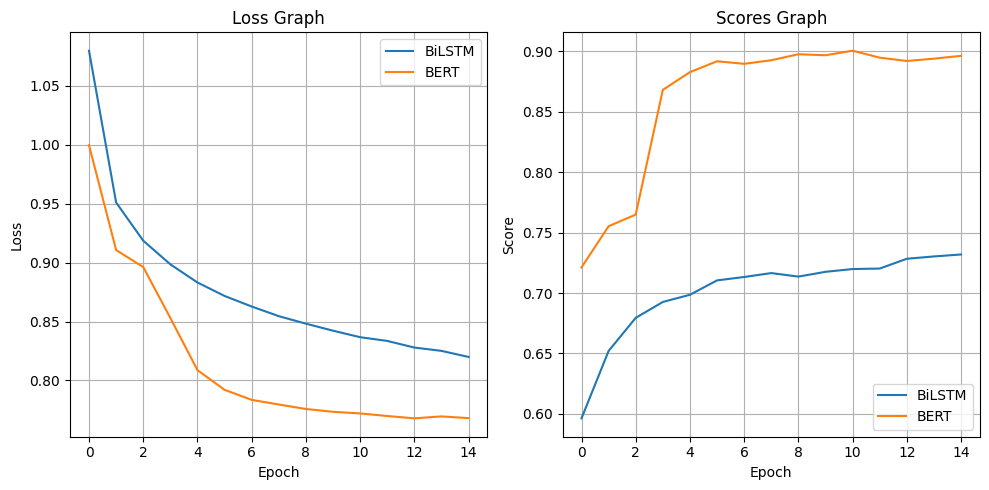

In [21]:
print(f'BiLSTM training time: {bilstm_training_time:4.2f} min')
print(f'BERT training time: {bert_training_time:4.2f} min')

bilstm_num_parameters = count_parameters(BiLSTM_model)
bert_num_parameters = count_parameters(BERT_model)
print(f'Number of parameters for the BiLSTM model: {bilstm_num_parameters}')
print(f'Number of parameters for the BERT model: {bert_num_parameters}')

bilstm_test_uas = test(BiLSTM_model, bilstm_test_dataloader)
print(f'Test set UAS score BiLSTM: {bilstm_test_uas:5.3f}')
bert_test_uas = test(BERT_model, bert_test_dataloader)
print(f'Test set UAS score BERT: {bert_test_uas:5.3f}')

# plotting the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(bilstm_losses, label='BiLSTM')
ax1.plot(bert_losses, label='BERT')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax1.set_title('Loss Graph')
ax1.grid(True)
ax1.legend()

ax2.plot(bilstm_scores, label='BiLSTM')
ax2.plot(bert_scores, label='BERT')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')

ax2.set_title('Scores Graph')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()

As expected the BERT model perfoms better than the BiLSTM one, both w.r.t. the average loss and the UAS score. This is due both to the difference in the volume of parameters (the BERT model has 100 times more parameters than the BiLSTM one) and the BERT embeddings exploiting more than 7 times the number of features used by the BiLSTM ones: it is quite obvious that more parameters/features carry more information, resulting in better performances. Moreover, the pre-trained architecture of the BERT encoder consitutes a big advantage: having a neural network already trained to produce efficient contextual embeddings clearly helps in having good tokens representations.

During our tests, we also tried to use just the last BERT encoder hidden layer instead of the concatenation of the last four: it led to halved training times but poorer results (still better than the BiLSTM model). Time complexity is the main trade-off with performance: the larger the model, the longer the time required to train it, the better the performances.
We feel the need to highlight how the training time of the BiLSTM model is a tenth of the one required by BERT.

In both of the graphs above, we can clearly see a significant improvement in BERT performances after the **third epoch**: we decided not to update the weights of the BERT encoder right from the start to give the MLP a chance of improving on its own. Starting the Fine-Tuning of the pretrained architecture after the third epoch we are sure not to incur the catastrophic forgetting phenomenon: we are aware that given the small number of epochs it is unlikely to happen, but in case of higher training times we believe that the BERT encoder weights should be periodically updated and not at every epoch like the MLP ones. Therefore we decided to make this choice guided more by the intent to respect a formalism than the actual need of it; we would like to stress, however, that the performances updating all weights from the start don't change significantly, thus the choice to leave as it is.

## SOTA Analysis
Searching for State of The Art models to compare with our implementation we struggled to find works with our specific and aimed task combined with our english-only dataset.
The model that comes closest to our needs is [UDPipe 2.0 + mBERT + FLAIR](https://paperswithcode.com/paper/evaluating-contextualized-embeddings-on-54).
The main problem for the comparison are:
- the model was published in 2019, so we don't have a real current SoTA;
- differently from our, the model is trained on 89 corpora in 54 different languages;
- the model tackles three different tasks: POS Tagging, Lemmatization and Dependency Parsing.

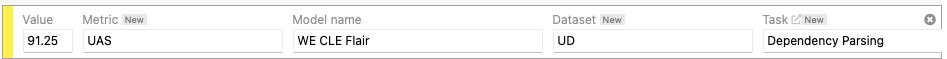

Given all that, UDPipe 2.0 + mBERT + FLAIR has a mean UAS score of 91.25, a little higher than our UAS score.
We have to take into accout that our model is more "specialized", training for a single language and a single task; therefore, we strongly believe that if the SoTA model was trained in the same way we trained our model, it would achieve much better results.

Other than the more complex architecture thought to handle the three tasks mentioned before, the main difference with our BERT model lies in the embeddings. The SoTA model exploits both the 768 BERT features, obtained by averaging the last four hidden layers of the encoder (capturing higher-level syntactic and possibly even semantic meaning), and the 4096 FLAIR features (capturing more morphological and orthographical information): as we have already said, having more features per token means having more information and therefore better results, at the cost of needing more resources.